In [1]:
from pathlib import Path
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(Path().resolve(), '../..')))
from ImportHelper import ImportHelper
ImportHelper()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
#from tensorflow import keras
from sklearn import preprocessing
from AlphaVantageCommodities import AlphaVantageCommodities
from PandasDataFrameNormalizer import PandasDataFrameNormalizer
from dotenv import load_dotenv
import seaborn as sns

load_dotenv()

2023-11-24 21:37:49.097475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 21:37:49.097558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 21:37:49.097579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 21:37:49.103229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2023-11-24 21:37:52.289362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:37:52.293991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:37:52.294419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


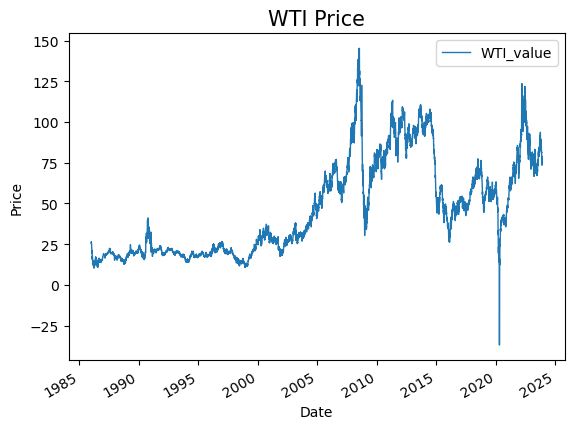

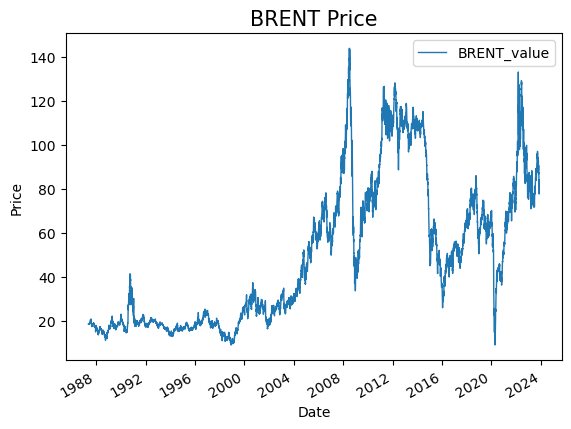

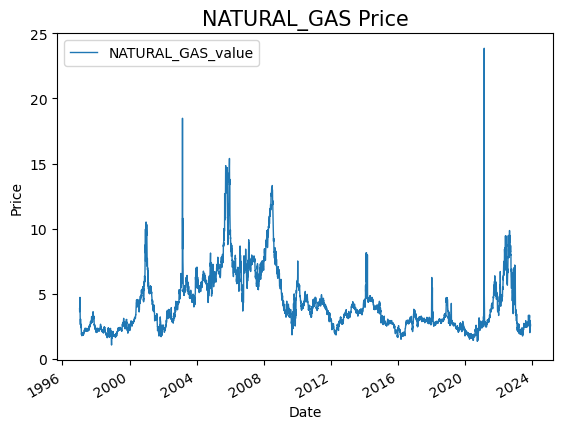

In [4]:
avc = AlphaVantageCommodities()
for symbol in avc.get_all_curated_series_ids():
    avc.plot_series_id(symbol)

In [5]:
df_merged = avc.get_data_as_pandas_df_multiple_series_ids(['WTI','BRENT','NATURAL_GAS'])

In [6]:
# keep nas for masking layer test
df_merged = df_merged.dropna()

In [7]:
#df_merged = df_merged.dropna(subset=['WTI_value']).fillna(0)

In [8]:
df_merged.head()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
2799,1997-01-07,26.250000,24.760000,3.82
2800,1997-01-08,26.549999,24.780001,3.80
2801,1997-01-09,26.299999,24.830000,3.61
2802,1997-01-10,26.150000,24.219999,3.92
2803,1997-01-13,25.200001,23.410000,4.00


<Axes: xlabel='date'>

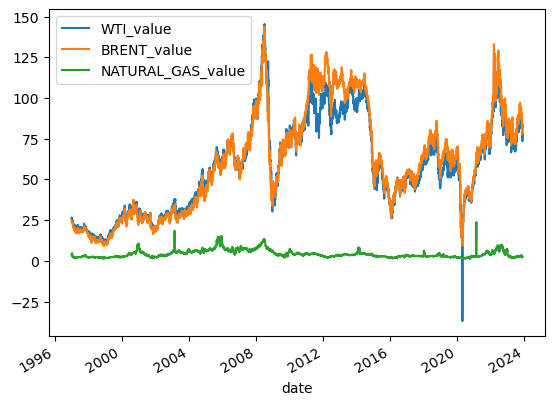

In [9]:
df_merged.plot(x="date")

<Axes: >

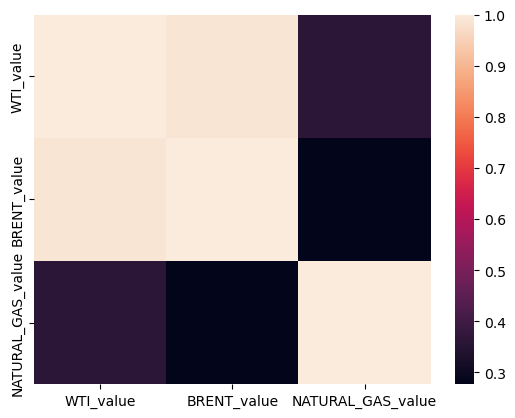

In [10]:
df_corr = df_merged.corr(numeric_only=True)
sns.heatmap(df_corr)

In [11]:
# Normalize data
normalizer_wti = PandasDataFrameNormalizer()
df_normalized = normalizer_wti.normalize_pandas_data_frame_column(df_merged,'WTI_value')

normalizer_brent = PandasDataFrameNormalizer()
df_normalized = normalizer_brent.normalize_pandas_data_frame_column(df_merged,'BRENT_value')

normalizer_natural_gas = PandasDataFrameNormalizer()
df_normalized = normalizer_natural_gas.normalize_pandas_data_frame_column(df_merged,'NATURAL_GAS_value')

In [12]:
df_normalized.tail()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
9539,2023-11-14,0.635690,0.556915,0.071898
9540,2023-11-15,0.626090,0.543567,0.080228
9541,2023-11-16,0.606067,0.508936,0.081543
9542,2023-11-17,0.622360,0.534817,0.068829
9543,2023-11-20,0.631302,0.549870,0.063130


In [13]:
df_normalized = df_normalized.dropna(subset=['WTI_value']).fillna(-1)

In [14]:
df_normalized.head()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
2799,1997-01-07,0.346865,0.116129,0.121438
2800,1997-01-08,0.348511,0.116277,0.120561
2801,1997-01-09,0.347139,0.116648,0.112231
2802,1997-01-10,0.346316,0.112125,0.125822
2803,1997-01-13,0.341105,0.106118,0.129329


<Axes: xlabel='date'>

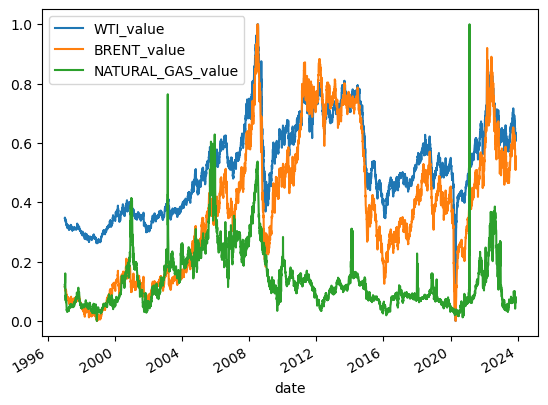

In [15]:
df_normalized.plot(x="date")

In [16]:
data = df_normalized[['WTI_value','BRENT_value','NATURAL_GAS_value']].to_numpy()
data

array([[0.3468649 , 0.11612904, 0.12143796],
       [0.34851062, 0.11627735, 0.12056115],
       [0.34713918, 0.11664813, 0.11223147],
       ...,
       [0.60606724, 0.5089359 , 0.08154318],
       [0.62236   , 0.5348165 , 0.06882945],
       [0.6313018 , 0.54987025, 0.06313021]], dtype=float32)

In [17]:
data.size

19998

In [18]:
np.shape(data)

(6666, 3)

In [19]:
print('Data lenght: ' + str(len(data)))

Data lenght: 6666


In [20]:
left_size = 0.8
split_at = int(left_size * len(data))
print('Split at: ' + str(split_at))

Split at: 5332


In [21]:
forecasting_label_steps = 10
feature_sequence_length = 100

x_train = data[0:split_at]
x_train_data = x_train[:-(feature_sequence_length+forecasting_label_steps)]
x_train_targets = x_train[feature_sequence_length+forecasting_label_steps:, 0]

x_test = data[split_at+1:]
x_test_data = x_test[:-(feature_sequence_length+forecasting_label_steps)]
x_test_targets = x_test[feature_sequence_length+forecasting_label_steps:, 0]

In [22]:
len(x_train_data)

5222

In [23]:
len(x_train_targets)

5222

In [24]:
len(x_test_data)

1223

In [25]:
x_train_data[100:,0]

array([0.3142246 , 0.3114817 , 0.3070931 , ..., 0.54287124, 0.5414998 ,
       0.5480279 ], dtype=float32)

In [26]:
x_train_targets

array([0.3065445 , 0.30572167, 0.3048988 , ..., 0.5644303 , 0.55993193,
       0.56448513], dtype=float32)

In [27]:
dataset_train = tf.keras.utils.timeseries_dataset_from_array(x_train_data, x_train_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=100)

2023-11-24 21:37:54.014975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:37:54.015521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:37:54.016015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:37:54.261193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-24 21:37:54.261433: I tensorflow/compile

In [28]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_test_data, x_test_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=100)

In [29]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (100, 100, 3)
Target shape: (100,)


In [30]:
model = Sequential()

model.add(InputLayer(input_shape = (inputs.shape[1], inputs.shape[2])))

model.add(Masking(mask_value=-1))

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.1))

model.add(LSTM(units = 200, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units = 200, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          41600     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 200)          240800    
                                                                 
 dropout_1 (Dropout)         (None, 100, 200)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 200)          320800    
                                                                 
 dropout_2 (Dropout)         (None, 100, 200)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 100)          1

In [31]:
path_checkpoint = "model_multi_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

In [32]:
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [33]:
history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100


2023-11-24 21:38:00.058961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 21:38:00.993685: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbb1896e740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 21:38:00.993733: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-11-24 21:38:00.998341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 21:38:01.076729: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 [==============================] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0942
Epoch 1: val_loss improved from inf to 0.01291, saving model to model_multi_checkpoint.h5
52/52 [==============================] - 10s 84ms/step - loss: 0.0146 - mean_absolute_error: 0.0942 - val_loss: 0.0129 - val_mean_absolute_error: 0.0927
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0578
Epoch 2: val_loss did not improve from 0.01291
52/52 [==============================] - 3s 58ms/step - loss: 0.0062 - mean_absolute_error: 0.0578 - val_loss: 0.0130 - val_mean_absolute_error: 0.0947
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0529
Epoch 3: val_loss improved from 0.01291 to 0.00833, saving model to model_multi_checkpoint.h5
52/52 [==============================] - 3s 58ms/step - loss: 0.0052 - mean_absolute_error: 0.0530 - val_loss: 0.0083 - val_mean_absolute_error: 0.0727
Epoch 

<Axes: >

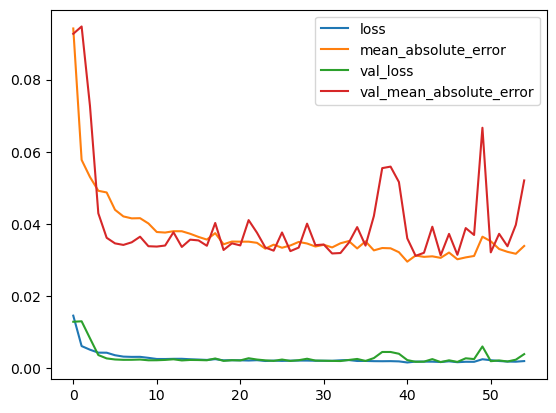

In [34]:
pd.DataFrame(history.history).plot()

In [35]:
model.load_weights(path_checkpoint)
# Re-evaluate the model
loss, acc = model.evaluate(dataset_test, verbose=2)

12/12 - 0s - loss: 0.0017 - mean_absolute_error: 0.0313 - 321ms/epoch - 27ms/step


In [36]:
def plot(input_data, predicted_data, output_compare, limit_right=None):
    if limit_right is not None:
        input_data = input_data[:limit_right]
        predicted_data = predicted_data[:limit_right]
        output_compare = output_compare[:limit_right]
        
    compare_y_shift = feature_sequence_length + forecasting_label_steps
    compare_y = list(range(compare_y_shift, compare_y_shift+ len(output_compare)))
    
    predicted_y_shift = feature_sequence_length + forecasting_label_steps
    predicted_y = list(range(predicted_y_shift, predicted_y_shift + len(predicted_data)))
    
    #input_data_limit = feature_sequence_length

    plt.figure(figsize=(20,6))
    plt.plot(input_data, label = "past", linestyle = 'dashed')
    plt.plot(predicted_y, predicted_data, label = "predicted")
    plt.plot(compare_y, output_compare, label = "real data", linestyle = 'dotted')
    plt.plot(feature_sequence_length, input_data[feature_sequence_length-1], "rx", label = "start prediction")
    plt.legend()
    plt.show()

In [37]:
for x, y in dataset_test.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [38]:
for x, y in dataset_train.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [39]:
predicted_dataset_train = model.predict(dataset_train)

52/52 [==============================] - 2s 21ms/step


In [40]:
len(predicted_dataset_train)

5123

In [41]:
len(predicted_dataset_train[:,0])

5123

In [42]:
x_train_data[:,0]

array([0.3468649 , 0.34851062, 0.34713918, ..., 0.54287124, 0.5414998 ,
       0.5480279 ], dtype=float32)

In [43]:
# inverse transforms
normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0])
normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0])
normalizer_wti.inverse_transform_numpy_array(x_train_targets)

array([18.899998, 18.75    , 18.600002, ..., 65.90999 , 65.09    ,
       65.92    ], dtype=float32)

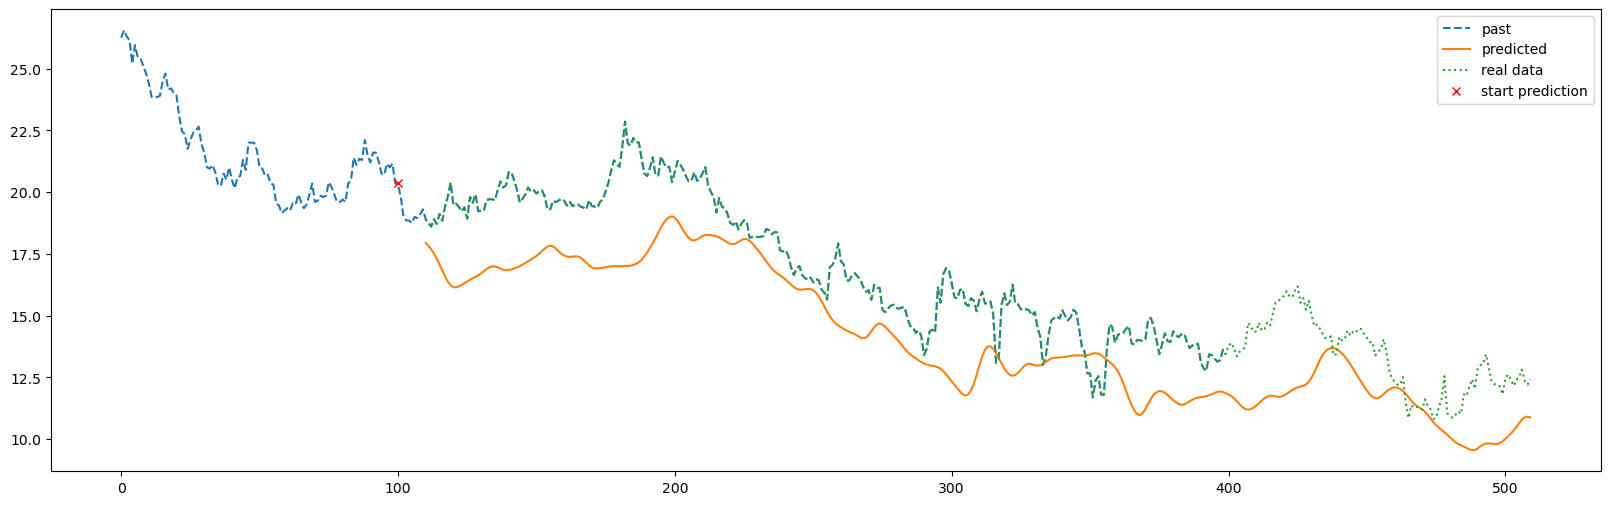

In [44]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0]), 
    normalizer_wti.inverse_transform_numpy_array(x_train_targets), 
    limit_right=400
)

In [45]:
predicted_dataset_test = model.predict(dataset_test)

12/12 [==============================] - 0s 22ms/step


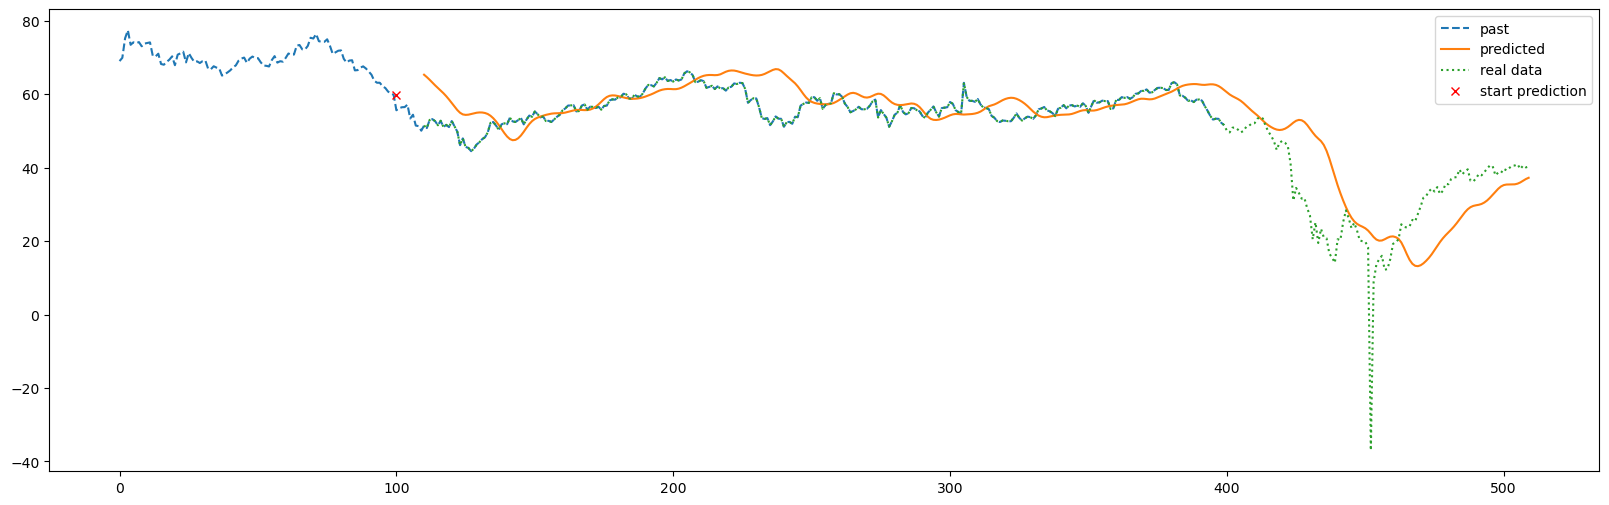

In [46]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_test_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_test[:,0]), 
    normalizer_wti.inverse_transform_numpy_array(x_test_targets), 
    limit_right=400
)